::: {.callout-note collapse="false"}
## Learning Outcomes
* Optimizing complex models 
* Identifying cases where straight calculus or geometric arguments won't help solve the loss function
* Applying gradient descent for numerical optimization
:::

At this point, we've grown quite familiar with the process of choosing a model and a corresponding loss function and optimizing parameters by choosing the values of $\theta$ that minimize the loss function. So far, we've optimized $\theta$ by
1. Using calculus to take the derivative of the loss function with respect to $\theta$, setting it equal to 0, and solve.
2. Using the geometric argument of orthogonality to derive the OLS solution $\hat{\theta} = (\mathbb{X}^T \mathbb{X})^{-1}\mathbb{X}^T \mathbb{Y}$.

One thing to note, however, is that the techniques we used above can only be applied if we make some big assumptions. For the calculus approach, we assumed that the loss function was differentiable at all points and that the algebra was manageable; for the geometric approach, OLS *only* applies when using a linear model with MSE loss. What happens when we have more complex models with different, more complex loss functions? The techniques we've learned so far will not work, so we need a new optimization technique: **gradient descent**. 

> **BIG IDEA**: use an algorithm instead of solving for an exact answer

# Minimizing a 1D Function

Let's consider an arbitrary function. Our goal is to find the value of $x$ that minimizes this function.


In [9]:
#| code-fold: true
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [10]:
def arbitrary(x):
    return (x**4 - 15*x**3 + 80*x**2 - 180*x + 144)/10

<img src="images/arbitrary.png" alt='arbitrary' width='600'>

## The Naive Approach: Guess and Check

Above, we saw that the minimum is somewhere around 5.3. Let's see if we can figure out how to find the exact minimum algorithmically from scratch. One very slow (and terrible) way would be manual guess-and-check.


In [11]:
arbitrary(6)

0.0

A somewhat better (but still slow) approach is to use brute force to try out a bunch of x values and return the one that yields the lowest loss.


In [12]:
def simple_minimize(f, xs):
    # Takes in a function f and a set of values xs. 
    # Calculates the value of the function f at all values x in xs
    # Takes the minimum value of f(x) and returns the corresponding value x 
    y = [f(x) for x in xs]  
    return xs[np.argmin(y)]

guesses = [5.3, 5.31, 5.32, 5.33, 5.34, 5.35]
simple_minimize(arbitrary, guesses)

5.33

This process is essentially the same as before where we made a graphical plot, it's just that we're only looking at 20 selected points.


In [13]:
#| code-fold: true
xs = np.linspace(1, 7, 200)
sparse_xs = np.linspace(1, 7, 5)

ys = arbitrary(xs)
sparse_ys = arbitrary(sparse_xs)

fig = px.line(x = xs, y = arbitrary(xs))
fig.add_scatter(x = sparse_xs, y = arbitrary(sparse_xs), mode = "markers")
fig.update_layout(showlegend= False)
fig.update_layout(autosize=False, width=800, height=600)
fig.show()

This basic approach suffers from three major flaws:
1. If the minimum is outside our range of guesses, the answer will be completely wrong.
2. Even if our range of guesses is correct, if the guesses are too coarse, our answer will be inaccurate.
3. It is absurdly computationally inefficient, considering potentially vast numbers of guesses that are useless.

## Scipy.optimize.minimize

One way to minimize this mathematical function is to use the `scipy.optimize.minimize` function. It takes a function and a starting guess and tries to find the minimum.


In [14]:
from scipy.optimize import minimize

# takes a function f and a starting point x0 and returns a readout 
# with the optimal input value of x which minimizes f
minimize(arbitrary, x0 = 3.5)

      fun: -0.13827491292966557
 hess_inv: array([[0.73848255]])
      jac: array([6.48573041e-06])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 3
     njev: 10
   status: 0
  success: True
        x: array([2.39275266])

`scipy.optimize.minimize` is great. It may also seem a bit magical. How could you write a function that can find the minimum of any mathematical function? There are a number of ways to do this, which we'll explore in today's lecture, eventually arriving at the important idea of **gradient descent**, which is the principle that `scipy.optimize.minimize` uses.

It turns out that under the hood, the `fit` method for `LinearRegression` models uses gradient descent. Gradient descent is also how much of machine learning works, including even advanced neural network models. 

In Data 100, the gradient descent process will usually be invisible to us, hidden beneath an abstraction layer. However, to be good data scientists, it's important that we know the underlying principles that optimization functions harness to find optimal parameters.


## Digging into Gradient Descent
Looking at the function across this domain, it is clear that the function's minimum value occurs around $\theta = 5.3$. Let's pretend for a moment that we *couldn't* see the full view of the cost function. How would we guess the value of $\theta$ that minimizes the function? 

It turns out that the first derivative of the function can give us a clue. In the plots below, the line indicates the value of the derivative of each value of $\theta$. The derivative is negative where it is red and positive where it is green.


Say we make a guess for the minimizing value of $\theta$. Remember that we read plots from left to right, and assume that our starting $\theta$ value is to the left of the optimal $\hat{\theta}$. If the guess "undershoots" the true minimizing value – our guess for $\theta$ is lower than the value of the $\hat{\theta}$ that minimizes the function – the derivative will be **negative**. This means that if we increase $\theta$ (move further to the right), then we **can decrease** our loss function further. If this guess "overshoots" the true minimizing value, the derivative will be positive, implying the converse.

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/step.png" alt='step' width='600'>
      </td>
    </tr>
  </table>
</div>

We can use this pattern to help formulate our next guess for the optimal $\hat{\theta}$. Consider the case where we've undershot $\theta$ by guessing too low of a value. We'll want our next guess to be greater in value than our previous guess – that is, we want to shift our guess to the right. You can think of this as following the slope "downhill" to the function's minimum value.

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/neg_step.png" alt='neg_step' width='600'>
      </td>
    </tr>
  </table>
</div>

If we've overshot $\hat{\theta}$ by guessing too high of a value, we'll want our next guess to be lower in value – we want to shift our guess for $\hat{\theta}$ to the left. 

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/pos_step.png" alt='pos_step' width='600'>
      </td>
    </tr>
  </table>
</div>

In other words, the derivative of the function at each point tells us the direction of our next guess.
* A negative slope means we want to step to the right, or move in the *positive* direction. 
* A positive slope means we want to step to the left, or move in the *negative* direction.

### Algorithm Attempt 1
Armed with this knowledge, let's try to see if we can use the derivative to optimize the function.

We start by making some guess for the minimizing value of $x$. Then, we look at the derivative of the function at this value of $x$, and step downhill in the *opposite* direction. We can express our new rule as a recurrence relation:

$$x^{(t+1)} = x^{(t)} - \frac{d}{dx} f(x^{(t)})$$

Translating this statement into English: we obtain **our next guess** for the minimizing value of $x$ at timestep $t+1$ ($x^{(t+1)}$) by taking **our last guess** ($x^{(t)}$) and subtracting the **derivative of the function** at that point ($\frac{d}{dx} f(x^{(t)})$).

A few steps are shown below, where the old step is shown as a transparent point, and the next step taken is the green-filled dot.

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/grad_descent_2.png" alt='grad_descent_2' width='600'>
      </td>
    </tr>
  </table>
</div>

Looking pretty good! We do have a problem though – once we arrive close to the minimum value of the function, our guesses "bounce" back and forth past the minimum without ever reaching it.

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/grad_descent_2.png" alt='grad_descent_2' width='600'>
      </td>
    </tr>
  </table>
</div>

In other words, each step we take when updating our guess moves us too far. We can address this by decreasing the size of each step. 

### Algorithm Attempt 2
Let's update our algorithm to use a **learning rate** (also sometimes called the step size), which controls how far we move with each update. We represent the learning rate with $\alpha$. 

$$x^{(t+1)} = x^{(t)} - \alpha \frac{d}{dx} f(x^{(t)})$$

A small $\alpha$ means that we will take small steps; a large $\alpha$ means we will take large steps. 

Updating our function to use $\alpha=0.3$, our algorithm successfully **converges** (settles on a solution and stops updating significantly, or at all) on the minimum value.

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/grad_descent_3.png" alt='grad_descent_3' width='600'>
      </td>
    </tr>
  </table>
</div>

### Convexity
In our analysis above, we focused our attention on the global minimum of the loss function. You may be wondering: what about the local minimum that's just to the left? 

If we had chosen a different starting guess for $\theta$, or a different value for the learning rate $\alpha$, our algorithm may have gotten "stuck" and converged on the local minimum, rather than on the true optimum value of loss. 

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/local.png" alt='local' width='600'>
      </td>
    </tr>
  </table>
</div>

If the loss function is **convex**, gradient descent is guaranteed to converge and find the global minimum of the objective function. Formally, a function $f$ is convex if:
$$tf(a) + (1-t)f(b) \geq f(ta + (1-t)b)$$
for all $a, b$ in the domain of $f$ and $t \in [0, 1]$.

To put this into words: if you drew a line between any two points on the curve, all values on the curve must be *on or below* the line. Importantly, any local minimum of a convex function is also its global minimum. 

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/convex.png" alt='convex' width='600'>
      </td>
    </tr>
  </table>
</div>

In summary, non-convex loss functions can cause problems with optimization. This means that our choice of loss function is a key factor in our modeling process. It turns out that MSE *is* convex, which is a major reason why it is such a popular choice of loss function.

## Gradient Descent in 1 Dimension

> **Terminology clarification**: In past lectures, we have used “loss” to refer to the error incurred on a *single* datapoint. In applications, we usually care more about the average error across *all* datapoints. Going forward, we will take the “model’s loss” to mean the model’s average error across the dataset. This is sometimes also known as the empirical risk, cost function, or objective function. $$L(\theta) = R(\theta) = \frac{1}{n} \sum_{i=1}^{n} l(y, \hat{y})$$

In our discussion above, we worked with some arbitrary function $f$. As data scientists, we will almost always work with gradient descent in the context of optimizing *models* – specifically, we want to apply gradient descent to find the minimum of a *loss function*. In a modeling context, our goal is to minimize a *loss function* by choosing the minimizing model *parameters*.

Recall our modeling workflow from the past few lectures: 
* Define a model with some parameters $\theta_i$
* Choose a loss function 
* Select the values of $\theta_i$ that minimize the loss function on the data

Gradient descent is a powerful technique for completing this last task. By applying the gradient descent algorithm, we can select values for our parameters $\theta_i$ that will lead to the model having minimal loss on the training data.

When using gradient descent in a modeling context:
* We make guesses for the minimizing $\theta_i$
* We compute the derivative of the loss function $L$

We can "translate" our gradient descent rule from before by replacing $x$ with $\theta$ and $f$ with $L$:

$$\theta^{(t+1)} = \theta^{(t)} - \alpha \frac{d}{d\theta} L(\theta^{(t)})$$

### Gradient Descent on the `tips` Dataset 
To see this in action, let's consider a case where we have a linear model with no offset. We want to predict the tip (y) given the price of a meal (x). To do this, we

* Choose a model: $\hat{y} = \theta_1 x$,
* Choose a loss function: $L(\theta) = MSE(\theta) = \frac{1}{n} \sum_{i=1}^n (y_i - \theta_1x_i)^2$.

Let's apply our `gradient_descent` function from before to optimize our model on the `tips` dataset. We will try to select the best parameter $\theta_i$ to predict the `tip` $y$ from the `total_bill` $x$.


In [15]:
df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


We can visualize the value of the MSE on our dataset for different possible choices of $\theta_1$. To optimize our model, we want to select the value of $\theta_1$ that leads to the lowest MSE.


In [16]:
#| code-fold: true
import plotly.graph_objects as go

def derivative_arbitrary(x):
    return (4*x**3 - 45*x**2 + 160*x - 180)/10

fig = go.Figure()
roots = np.array([2.3927, 3.5309, 5.3263])

fig.add_trace(go.Scatter(x = xs, y = arbitrary(xs), 
                         mode = "lines", name = "f"))
fig.add_trace(go.Scatter(x = xs, y = derivative_arbitrary(xs), 
                         mode = "lines", name = "df", line = {"dash": "dash"}))
fig.add_trace(go.Scatter(x = np.array(roots), y = 0*roots, 
                         mode = "markers", name = "df = zero", marker_size = 12))
fig.update_layout(font_size = 20, yaxis_range=[-1, 3])
fig.update_layout(autosize=False, width=800, height=600)
fig.show()

To apply gradient descent, we need to compute the derivative of the loss function with respect to our parameter $\theta_1$.
* Given our loss function, $$L(\theta) = MSE(\theta) = \frac{1}{n} \sum_{i=1}^n (y_i - \theta_1x_i)^2$$
* We take the derivative with respect to $\theta_1$ $$\frac{\partial}{\partial \theta_{1}} L(\theta_1^{(t)}) = \frac{-2}{n} \sum_{i=1}^n (y_i - \theta_1^{(t)} x_i) x_i$$
* Which results in the gradient descent update rule
$$\theta_1^{(t+1)} = \theta_1^{(t)} - \alpha \frac{d}{d\theta}L(\theta_1^{(t)})$$

for some learning rate $\alpha$.

Implementing this in code, we can visualize the MSE loss on the `tips` data. **MSE is convex**, so there is one global minimum.


Final guess for theta_1: 0.14369554654231262


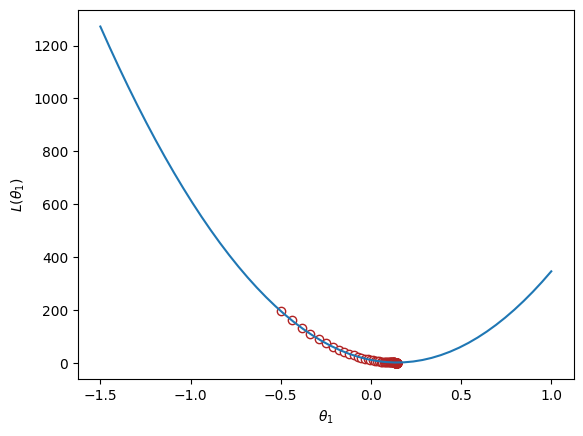

In [17]:
#| code-fold: true
def gradient_descent(df, initial_guess, alpha, n):
    """Performs n steps of gradient descent on df using learning rate alpha starting
       from initial_guess. Returns a numpy array of all guesses over time."""
    guesses = [initial_guess]
    current_guess = initial_guess
    while len(guesses) < n:
        current_guess = current_guess - alpha * df(current_guess)
        guesses.append(current_guess)
        
    return np.array(guesses)

def mse_single_arg(theta_1):
    """Returns the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    return np.mean((y_hat - y_obs) ** 2)

def mse_loss_derivative_single_arg(theta_1):
    """Returns the derivative of the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    
    return np.mean(2 * (y_hat - y_obs) * x)

loss_df = pd.DataFrame({"theta_1":np.linspace(-1.5, 1), "MSE":[mse_single_arg(theta_1) for theta_1 in np.linspace(-1.5, 1)]})

trajectory = gradient_descent(mse_loss_derivative_single_arg, -0.5, 0.0001, 100)

plt.plot(loss_df["theta_1"], loss_df["MSE"])
plt.scatter(trajectory, [mse_single_arg(guess) for guess in trajectory], c="white", edgecolor="firebrick")
plt.scatter(trajectory[-1], mse_single_arg(trajectory[-1]), c="firebrick")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$L(\theta_1)$");

print(f"Final guess for theta_1: {trajectory[-1]}")

## Gradient Descent on Multi-Dimensional Models
The function we worked with above was one-dimensional – we were only minimizing the function with respect to a single parameter, $\theta$. However, models usually have a cost function with multiple parameters that need to be optimized. For example, simple linear regression has 2 parameters: $\hat{y} + \theta_0 + \theta_1x$, and multiple linear regression has $p+1$ parameters: $\mathbb{Y} = \theta_0 + \theta_1 \Bbb{X}_{:,1} + \theta_2 \Bbb{X}_{:,2} + \cdots + \theta_p \Bbb{X}_{:,p}$

We'll need to expand gradient descent so we can update our guesses for all model parameters, all in one go.

With multiple parameters to optimize, we consider a **loss surface**, or the model's loss for a particular *combination* of possible parameter values.


In [18]:
#| code-fold: true
import plotly.graph_objects as go


def mse_loss(theta, X, y_obs):
    y_hat = X @ theta
    return np.mean((y_hat - y_obs) ** 2)    

tips_with_bias = df.copy()
tips_with_bias["bias"] = 1
tips_with_bias = tips_with_bias[["bias", "total_bill"]]

uvalues = np.linspace(0, 2, 10)
vvalues = np.linspace(-0.1, 0.35, 10)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

def mse_loss_single_arg(theta):
    return mse_loss(theta, tips_with_bias, df["tip"])

MSE = np.array([mse_loss_single_arg(t) for t in thetas.T])

loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

ind = np.argmin(MSE)
optimal_point = go.Scatter3d(name = "Optimal Point",
    x = [thetas.T[ind,0]], y = [thetas.T[ind,1]], 
    z = [MSE[ind]],
    marker=dict(size=10, color="red"))

fig = go.Figure(data=[loss_surface, optimal_point])
fig.update_layout(scene = dict(
    xaxis_title = "theta0",
    yaxis_title = "theta1",
    zaxis_title = "MSE"), autosize=False, width=800, height=600)

fig.show()

We can also visualize a bird's-eye view of the loss surface from above using a contour plot:


In [19]:
contour = go.Contour(x=u[0], y=v[:, 0], z=np.reshape(MSE, u.shape))
fig = go.Figure(contour)
fig.update_layout(
    xaxis_title = "theta0",
    yaxis_title = "theta1", autosize=False, width=800, height=600)

fig.show()

### The Gradient Vector
As before, the derivative of the loss function tells us the best way towards the minimum value.

On a 2D (or higher) surface, the best way to go down (gradient) is described by a *vector*.

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/loss_surface.png" alt='loss_surface' width='600'>
      </td>
    </tr>
  </table>
</div>

> Math Aside: Partial Derivatives
> - For an equation with multiple variables, we take a **partial derivative** by differentiating with respect to just one variable at a time. The partial derivative is denoted with a $\partial$. Intuitively, we want to see how the function changes if we only vary one variable while holding other variables constant. 
> - Using $f(x, y) = 3x^2 + y$ as an example,
>   - taking the partial derivative with respect to x and treating y as a constant gives us $\frac{\partial f}{\partial x} = 6x$
>   - taking the partial derivative with respect to y and treating x as a constant gives us $\frac{\partial f}{\partial y} = 1$

For the *vector* of parameter values $\vec{\theta} = \begin{bmatrix}
           \theta_{0} \\
           \theta_{1} \\
         \end{bmatrix}$, we take the *partial derivative* of loss with respect to each parameter: $\frac{\partial L}{\partial \theta_0}$ and $\frac{\partial L}{\partial \theta_1}$.

The **gradient vector** is therefore 
$$\nabla_\theta L =  \begin{bmatrix} \frac{\partial L}{\partial \theta_0} \\ \frac{\partial L}{\partial \theta_1} \\... \end{bmatrix}$$
where $\nabla_\theta L$ always points in the downhill direction of the surface. 

We can use this to update our 1D gradient rule for models with multiple parameters. 

* Recall our 1D update rule: $$\theta^{(t+1)} = \theta^{(t)} - \alpha \frac{d}{d\theta}L(\theta^{(t)})$$ 
* For models with multiple parameters, we work in terms of vectors:
$$\begin{bmatrix}
           \theta_{0}^{(t+1)} \\
           \theta_{1}^{(t+1)} \\
           \vdots
         \end{bmatrix}
=
\begin{bmatrix}
           \theta_{0}^{(t)} \\
           \theta_{1}^{(t)} \\
           \vdots
         \end{bmatrix}
- \alpha
\begin{bmatrix}
           \frac{\partial L}{\partial \theta_{0}} \\
           \frac{\partial L}{\partial \theta_{1}} \\
           \vdots \\
         \end{bmatrix}$$
  
* Written in a more compact form, $$\vec{\theta}^{(t+1)} = \vec{\theta}^{(t)} - \alpha \nabla_{\vec{\theta}} L(\theta^{(t)}) $$

  * $\theta$ is a vector with our model weights
  * $L$ is the loss function
  * $\alpha$ is the learning rate (ours is constant, but other techniques use an $\alpha$ that decreases over time)
  * $\vec{\theta}^{(t)}$ is the current value of $\theta$
  * $\vec{\theta}^{(t+1)}$ is the next value of $\theta$
  * $\nabla_{\vec{\theta}} L(\theta^{(t)})$ is the gradient of the loss function evaluated at the current $\vec{\theta}^{(t)}$

## Batch, Mini-Batch Gradient Descent and Stochastic Gradient Descent

Formally, the algorithm we derived above is called **batch gradient descent.** For each iteration of the algorithm, the derivative of loss is computed across the *entire* batch of all $n$ datapoints. While this update rule works well in theory, it is not practical in most circumstances. For large datasets (with perhaps billions of datapoints), finding the gradient across all the data is incredibly computationally taxing; gradient descent will converge slowly because each individual update is slow.

**Mini-batch gradient descent** tries to address this issue. In mini-batch descent, only a *subset* of the data is used to estimate the gradient. The **batch size** is the number of data points used in each subset. 

Each complete "pass" through the data is known as a **training epoch**. In a single **training epoch** of mini-batch gradient descent, we

* Compute the gradient on the first x% of the data. Update the parameter guesses.
* Compute the gradient on the next x% of the data. Update the parameter guesses.
* $\dots$
* Compute the gradient on the last x% of the data. Update the parameter guesses.

Every data point is once in a single training epoch. We then perform several training epochs until we're satisfied.

In the most extreme case, we might choose a batch size of only 1 datapoint – that is, a single datapoint is used to estimate the gradient of loss with each update step. This is known as **stochastic gradient descent**.
In a single **training epoch** of stochastic gradient descent, we

* Compute the gradient on the first data point. Update the parameter guesses.
* Compute the gradient on the next data point. Update the parameter guesses.
* $\dots$
* Compute the gradient on the last data point. Update the parameter guesses.

Batch gradient descent is a deterministic technique – because the entire dataset is used at each update iteration, the algorithm will always advance towards the minimum of the loss surface. In contrast, both mini-batch and stochastic gradient descent involve an element of randomness. Since only a subset of the full data is used to update the guess for $\vec{\theta}$ at each iteration, there's a chance the algorithm will not progress towards the true minimum of loss with each update. Over the longer term, these stochastic techniques should still converge towards the optimal solution. 

The diagrams below represent a "bird's eye view" of a loss surface from above. Notice that batch gradient descent takes a direct path towards the optimal $\hat{\theta}$. Stochastic gradient descent, in contrast, "hops around" on its path to the minimum point on the loss surface. This reflects the randomness of the sampling process at each update step.

<div align="middle">
  <table style="width:100%">
    <tr align="center">
      <td><img src="images/stochastic.png" alt='stochastic' width='600'>
      </td>
    </tr>
  </table>
</div>
